# 🔬 Cell Motility Segmentation

## 🛠 Install Modules

❗Don't forget to restart the runtime

In [1]:
%%capture
!pip install segmentation-models-pytorch
!pip install albumentations==0.4.6
!pip install pytorch-lightning
!pip install torchtext

## 📚 Import Modules

In [1]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm import tqdm
tqdm.pandas()
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd
import re
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, KFold
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.utils.metrics import Accuracy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import pytorch_lightning as pl
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import warnings
warnings.filterwarnings("ignore")
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

## 💾 Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## ⚙️ Model Configuration 

In [3]:
class CFG:
    seed            = 35
    debug           = False # set debug=False for Full Training
    model_name      = 'Unet'
    backbone        = 'timm-regnetx_320'
    encoder_weights = 'imagenet'
    img_size        = [256, 256]
    in_channels     = 3
    exp_name        = model_name + '-' + backbone + '-' + encoder_weights + '-' + str(img_size[0]) + 'x' + str(img_size[1]) + '-' + 'CM.pth'
    train_bs        = 2 
    valid_bs        = 4
    epochs          = 30
    lr              = 1e-4
    scheduler       = 'CosineAnnealingLR'
    min_lr          = 1e-6
    wd              = 5e-6
    num_classes     = 1
    device          = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## ❗ Reproducibility

In [4]:
def set_seed(seed = 42):
    """
    Sets the seed of the entire notebook 
    so results are the same every time we run.
    This is for REPRODUCIBILITY.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CFG.seed)

> SEEDING DONE


## 📁 Dataset

In [5]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 img_paths, 
                 mask_paths=None, 
                 transforms=None):
        """
        Run once when instantiating the Dataset object.
        """
        self.img_paths = self._get_file_dir(img_paths)
        self.mask_paths = self._get_file_dir(mask_paths) if mask_paths is not None else mask_paths
        self.transforms = transforms
        
    def __len__(self):
        """
        Returns the number of samples in our dataset.
        Returns
        -------    
        num_datas : int    
            Number of datas.
        """
        return len(self.img_paths)
    
    def __getitem__(self, index):
        """
        Loads and returns a sample from the dataset at 
        the given index idx. Based on the index, it 
        identifies the image’s location on disk, 
        converts that to a tensor using read_image, 
        retrieves the corresponding label from the 
        ground truth data in self.mask_paths, calls the transform 
        functions on them (if applicable), and returns 
        the tensor image and corresponding label in a tuple.
        Returns
        -------   
        img, mask : torch.Tensor
            The transformed image and its corresponding 
            mask image. If the mask path is None, it 
            will only return the transformed image.
            output_shape_mask: (batch_size, 1, img_size, img_size)
            output_shape_img: (batch_size, 3, img_size, img_size)
        """
        img_path = self.img_paths[index]
        img = Image.open(img_path).convert("RGB")
        img = np.array(img, dtype=np.uint8)
        if self.mask_paths is not None:
            mask_path = self.mask_paths[index]
            mask = Image.open(mask_path)
            mask = np.array(mask)
            mask[:, :][mask[:, :] > 1] = 1
            if self.transforms:
                data = self.transforms(
                    image=img, mask=mask
                )
                img  = data['image']
                mask = data['mask']
            mask = np.expand_dims(mask, axis=0) 
            return img, mask
        else:
            if self.transforms:
                data = self.transforms(image=img)
                img = data['image']
            return img

    def _get_file_dir(self, directory):
        """
        Returns files in the entered directory.
        Parameters
        ----------
        directory : string
            File path.
        Returns
        ----------
        directories: list
            All files in the directory.
        """
        def atoi(text):
            return int(text) if text.isdigit() else text
            
        def natural_keys(text):
            return [atoi(c) for c in re.split('(\d+)',text)]

        for roots,dirs,files in os.walk(directory):               
            if files:
                directories = [roots + os.sep + file for file in  files]
                directories.sort(key=natural_keys)

        return directories

### DataLoader

📂 Data Paths

In [6]:
train_img_path = '/content/gdrive/MyDrive/Datas/cell_motility_data/train/images' 
train_mask_path = '/content/gdrive/MyDrive/Datas/cell_motility_data/train/masks'
val_img_path = '/content/gdrive/MyDrive/Datas/cell_motility_data/val/images'
val_mask_path = '/content/gdrive/MyDrive/Datas/cell_motility_data/val/masks'
test_img_path = '/content/gdrive/MyDrive/Datas/cell_motility_data/test/images'
test_mask_path = '/content/gdrive/MyDrive/Datas/cell_motility_data/test/masks'

☂ Augmentations

In [7]:
data_transforms = {
    "train": A.Compose([
        A.Resize(*CFG.img_size),
        A.CLAHE(p=0.35),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=90, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
        A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
                         min_holes=5, fill_value=0, p=0.5),
        ToTensorV2()], p=1.0),
    
    "valid": A.Compose([
        A.Resize(*CFG.img_size),
        ToTensorV2()], p=1.0)
}

In [8]:
train_dataset = BuildDataset(train_img_path, train_mask_path, transforms=data_transforms['train'])
val_dataset = BuildDataset(val_img_path, val_mask_path, transforms=data_transforms['valid'])
test_dataset = BuildDataset(test_img_path, test_mask_path, transforms=data_transforms['valid'])

train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs, 
                            num_workers=4, shuffle=True, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=CFG.valid_bs, 
                            num_workers=4, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=CFG.valid_bs, 
                            num_workers=4, shuffle=False, pin_memory=True)

In [9]:
imgs, msks = next(iter(train_loader))
imgs = imgs.permute((0, 2, 3, 1))
msks = msks.permute((0, 2, 3, 1))
imgs.size(), msks.size()

(torch.Size([2, 256, 256, 3]), torch.Size([2, 256, 256, 1]))

## 📈 Visualization

In [10]:
def plot_batch(imgs, msks, size=3):
    for idx in range(size):
        plt.figure(figsize=(4*3, 5))

        plt.subplot(1, 3, 1); plt.imshow(imgs[idx])
        plt.title('image', fontsize=15)
        plt.axis('OFF')

        plt.subplot(1, 3, 2); plt.imshow(np.squeeze(msks[idx]))
        plt.title('mask', fontsize=15)
        plt.axis('OFF')

        plt.subplot(1, 3, 3); plt.imshow(imgs[idx]); plt.imshow(np.squeeze(msks[idx]), alpha=0.3)
        plt.title('overlay', fontsize=15)
        plt.axis('OFF')
        
        plt.tight_layout()
        plt.show()

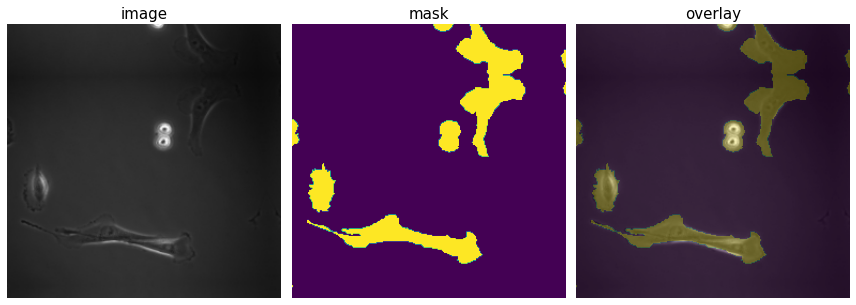

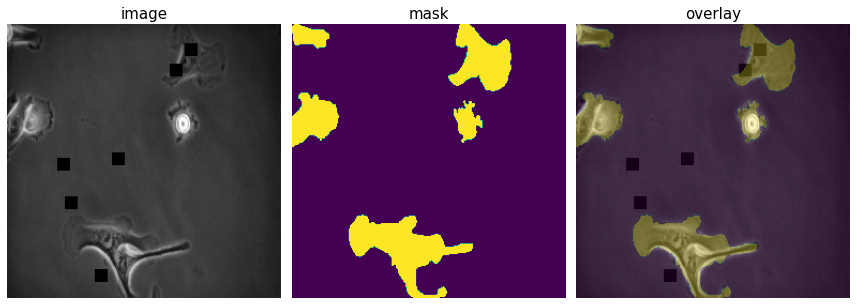

In [11]:
plot_batch(imgs, msks, size=CFG.train_bs)

## 🚆 Training with Pytorch Lightning

### 📦 Model

In [13]:
class SegmentationModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, 
                 encoder_weights, in_channels, 
                 out_classes, loss, metric, **kwargs):
        super().__init__(**kwargs)
        self.model = smp.create_model(
            arch, 
            encoder_name=encoder_name,
            encoder_weights=encoder_weights, 
            in_channels=in_channels, 
            classes=out_classes, 
            **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = loss
        self.criterion = metric

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch[0]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch[1]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        acc   = self.criterion(pred_mask, mask)

        return {
            "loss": loss,
            "acc": acc,
        }

    def shared_epoch_end(self, outputs, stage):

        metrics = {
            f"{stage}_per_image_iou": outputs[-1],
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(
            self.parameters(), 
            lr=CFG.lr, 
            weight_decay=CFG.wd
        )

### 🔌 Training

<div align="center">
 
![logo](https://i.ibb.co/dc1XdhT/Segmentation-Models-V2-Side-1-1.png)  
**Python library with Neural Networks for Image  
Segmentation based on [PyTorch](https://pytorch.org/).**  

[![Generic badge](https://img.shields.io/badge/License-MIT-<COLOR>.svg?style=for-the-badge)](https://github.com/qubvel/segmentation_models.pytorch/blob/master/LICENSE) 
[![GitHub Workflow Status (branch)](https://img.shields.io/github/workflow/status/qubvel/segmentation_models.pytorch/CI/master?style=for-the-badge&logo=github)](https://github.com/qubvel/segmentation_models.pytorch/actions/workflows/tests.yml) 
[![Read the Docs](https://img.shields.io/readthedocs/smp?style=for-the-badge&logo=readthedocs&logoColor=white)](https://smp.readthedocs.io/en/latest/) 
<br>
[![PyPI](https://img.shields.io/pypi/v/segmentation-models-pytorch?color=blue&style=for-the-badge&logo=pypi&logoColor=white)](https://pypi.org/search/?q=segmentation-models-pytorch) 
[![PyPI - Downloads](https://img.shields.io/pypi/dm/segmentation-models-pytorch?style=for-the-badge&color=blue)](https://pepy.tech/project/segmentation-models-pytorch) 
<br>
[![PyTorch - Version](https://img.shields.io/badge/PYTORCH-1.4+-red?style=for-the-badge&logo=pytorch)](https://pepy.tech/project/segmentation-models-pytorch) 
[![Python - Version](https://img.shields.io/badge/PYTHON-3.6+-red?style=for-the-badge&logo=python&logoColor=white)](https://pepy.tech/project/segmentation-models-pytorch) 

</div>

 
[📚 Project Documentation 📚](http://smp.readthedocs.io/)

Visit [Read The Docs Project Page](https://smp.readthedocs.io/) or read following README to know more about Segmentation Models Pytorch (SMP for short) library





📦 Models <a name="models"></a>

Architectures <a name="architectures"></a>
 - Unet [[paper](https://arxiv.org/abs/1505.04597)] [[docs](https://smp.readthedocs.io/en/latest/models.html#unet)]
 - Unet++ [[paper](https://arxiv.org/pdf/1807.10165.pdf)] [[docs](https://smp.readthedocs.io/en/latest/models.html#id2)]
 - MAnet [[paper](https://ieeexplore.ieee.org/abstract/document/9201310)] [[docs](https://smp.readthedocs.io/en/latest/models.html#manet)]
 - Linknet [[paper](https://arxiv.org/abs/1707.03718)] [[docs](https://smp.readthedocs.io/en/latest/models.html#linknet)]
 - FPN [[paper](http://presentations.cocodataset.org/COCO17-Stuff-FAIR.pdf)] [[docs](https://smp.readthedocs.io/en/latest/models.html#fpn)]
 - PSPNet [[paper](https://arxiv.org/abs/1612.01105)] [[docs](https://smp.readthedocs.io/en/latest/models.html#pspnet)]
 - PAN [[paper](https://arxiv.org/abs/1805.10180)] [[docs](https://smp.readthedocs.io/en/latest/models.html#pan)]
 - DeepLabV3 [[paper](https://arxiv.org/abs/1706.05587)] [[docs](https://smp.readthedocs.io/en/latest/models.html#deeplabv3)]
 - DeepLabV3+ [[paper](https://arxiv.org/abs/1802.02611)] [[docs](https://smp.readthedocs.io/en/latest/models.html#id9)]

Encoders <a name="encoders"></a>

The following is a list of supported encoders in the SMP. Select the appropriate family of encoders and click to expand the table and select a specific encoder and its pre-trained weights (`encoder_name` and `encoder_weights` parameters).

<details>
<summary style="margin-left: 25px;">ResNet</summary>
<div style="margin-left: 25px;">

|Encoder                         |Weights                         |Params, M                       |
|--------------------------------|:------------------------------:|:------------------------------:|
|resnet18                        |imagenet / ssl / swsl           |11M                             |
|resnet34                        |imagenet                        |21M                             |
|resnet50                        |imagenet / ssl / swsl           |23M                             |
|resnet101                       |imagenet                        |42M                             |
|resnet152                       |imagenet                        |58M                             |

</div>
</details>

<details>
<summary style="margin-left: 25px;">ResNeXt</summary>
<div style="margin-left: 25px;">

|Encoder                         |Weights                         |Params, M                       |
|--------------------------------|:------------------------------:|:------------------------------:|
|resnext50_32x4d                 |imagenet / ssl / swsl           |22M                             |
|resnext101_32x4d                |ssl / swsl                      |42M                             |
|resnext101_32x8d                |imagenet / instagram / ssl / swsl|86M                         |
|resnext101_32x16d               |instagram / ssl / swsl          |191M                            |
|resnext101_32x32d               |instagram                       |466M                            |
|resnext101_32x48d               |instagram                       |826M                            |

</div>
</details>

<details>
<summary style="margin-left: 25px;">ResNeSt</summary>
<div style="margin-left: 25px;">

|Encoder                         |Weights                         |Params, M                       |
|--------------------------------|:------------------------------:|:------------------------------:|
|timm-resnest14d                 |imagenet                        |8M                              |
|timm-resnest26d                 |imagenet                        |15M                             |
|timm-resnest50d                 |imagenet                        |25M                             |
|timm-resnest101e                |imagenet                        |46M                             |
|timm-resnest200e                |imagenet                        |68M                             |
|timm-resnest269e                |imagenet                        |108M                            |
|timm-resnest50d_4s2x40d         |imagenet                        |28M                             |
|timm-resnest50d_1s4x24d         |imagenet                        |23M                             |

</div>
</details>

<details>
<summary style="margin-left: 25px;">Res2Ne(X)t</summary>
<div style="margin-left: 25px;">

|Encoder                         |Weights                         |Params, M                       |
|--------------------------------|:------------------------------:|:------------------------------:|
|timm-res2net50_26w_4s           |imagenet                        |23M                             |
|timm-res2net101_26w_4s          |imagenet                        |43M                             |
|timm-res2net50_26w_6s           |imagenet                        |35M                             |
|timm-res2net50_26w_8s           |imagenet                        |46M                             |
|timm-res2net50_48w_2s           |imagenet                        |23M                             |
|timm-res2net50_14w_8s           |imagenet                        |23M                             |
|timm-res2next50                 |imagenet                        |22M                             |

</div>
</details>

<details>
<summary style="margin-left: 25px;">RegNet(x/y)</summary>
<div style="margin-left: 25px;">

|Encoder                         |Weights                         |Params, M                       |
|--------------------------------|:------------------------------:|:------------------------------:|
|timm-regnetx_002                |imagenet                        |2M                              |
|timm-regnetx_004                |imagenet                        |4M                              |
|timm-regnetx_006                |imagenet                        |5M                              |
|timm-regnetx_008                |imagenet                        |6M                              |
|timm-regnetx_016                |imagenet                        |8M                              |
|timm-regnetx_032                |imagenet                        |14M                             |
|timm-regnetx_040                |imagenet                        |20M                             |
|timm-regnetx_064                |imagenet                        |24M                             |
|timm-regnetx_080                |imagenet                        |37M                             |
|timm-regnetx_120                |imagenet                        |43M                             |
|timm-regnetx_160                |imagenet                        |52M                             |
|timm-regnetx_320                |imagenet                        |105M                            |
|timm-regnety_002                |imagenet                        |2M                              |
|timm-regnety_004                |imagenet                        |3M                              |
|timm-regnety_006                |imagenet                        |5M                              |
|timm-regnety_008                |imagenet                        |5M                              |
|timm-regnety_016                |imagenet                        |10M                             |
|timm-regnety_032                |imagenet                        |17M                             |
|timm-regnety_040                |imagenet                        |19M                             |
|timm-regnety_064                |imagenet                        |29M                             |
|timm-regnety_080                |imagenet                        |37M                             |
|timm-regnety_120                |imagenet                        |49M                             |
|timm-regnety_160                |imagenet                        |80M                             |
|timm-regnety_320                |imagenet                        |141M                            |

</div>
</details>

<details>
<summary style="margin-left: 25px;">GERNet</summary>
<div style="margin-left: 25px;">

|Encoder                         |Weights                         |Params, M                       |
|--------------------------------|:------------------------------:|:------------------------------:|
|timm-gernet_s                   |imagenet                        |6M                              |
|timm-gernet_m                   |imagenet                        |18M                             |
|timm-gernet_l                   |imagenet                        |28M                             |

</div>
</details>

<details>
<summary style="margin-left: 25px;">SE-Net</summary>
<div style="margin-left: 25px;">

|Encoder                         |Weights                         |Params, M                       |
|--------------------------------|:------------------------------:|:------------------------------:|
|senet154                        |imagenet                        |113M                            |
|se_resnet50                     |imagenet                        |26M                             |
|se_resnet101                    |imagenet                        |47M                             |
|se_resnet152                    |imagenet                        |64M                             |
|se_resnext50_32x4d              |imagenet                        |25M                             |
|se_resnext101_32x4d             |imagenet                        |46M                             |

</div>
</details>

<details>
<summary style="margin-left: 25px;">SK-ResNe(X)t</summary>
<div style="margin-left: 25px;">

|Encoder                         |Weights                         |Params, M                       |
|--------------------------------|:------------------------------:|:------------------------------:|
|timm-skresnet18                 |imagenet                        |11M                             |
|timm-skresnet34                 |imagenet                        |21M                             |
|timm-skresnext50_32x4d          |imagenet                        |25M                             |

</div>
</details>

<details>
<summary style="margin-left: 25px;">DenseNet</summary>
<div style="margin-left: 25px;">

|Encoder                         |Weights                         |Params, M                       |
|--------------------------------|:------------------------------:|:------------------------------:|
|densenet121                     |imagenet                        |6M                              |
|densenet169                     |imagenet                        |12M                             |
|densenet201                     |imagenet                        |18M                             |
|densenet161                     |imagenet                        |26M                             |

</div>
</details>

<details>
<summary style="margin-left: 25px;">Inception</summary>
<div style="margin-left: 25px;">

|Encoder                         |Weights                         |Params, M                       |
|--------------------------------|:------------------------------:|:------------------------------:|
|inceptionresnetv2               |imagenet /  imagenet+background |54M                             |
|inceptionv4                     |imagenet /  imagenet+background |41M                             |
|xception                        |imagenet                        |22M                             |

</div>
</details>

<details>
<summary style="margin-left: 25px;">EfficientNet</summary>
<div style="margin-left: 25px;">

|Encoder                         |Weights                         |Params, M                       |
|--------------------------------|:------------------------------:|:------------------------------:|
|efficientnet-b0                 |imagenet                        |4M                              |
|efficientnet-b1                 |imagenet                        |6M                              |
|efficientnet-b2                 |imagenet                        |7M                              |
|efficientnet-b3                 |imagenet                        |10M                             |
|efficientnet-b4                 |imagenet                        |17M                             |
|efficientnet-b5                 |imagenet                        |28M                             |
|efficientnet-b6                 |imagenet                        |40M                             |
|efficientnet-b7                 |imagenet                        |63M                             |
|timm-efficientnet-b0            |imagenet / advprop / noisy-student|4M                              |
|timm-efficientnet-b1            |imagenet / advprop / noisy-student|6M                              |
|timm-efficientnet-b2            |imagenet / advprop / noisy-student|7M                              |
|timm-efficientnet-b3            |imagenet / advprop / noisy-student|10M                             |
|timm-efficientnet-b4            |imagenet / advprop / noisy-student|17M                             |
|timm-efficientnet-b5            |imagenet / advprop / noisy-student|28M                             |
|timm-efficientnet-b6            |imagenet / advprop / noisy-student|40M                             |
|timm-efficientnet-b7            |imagenet / advprop / noisy-student|63M                             |
|timm-efficientnet-b8            |imagenet / advprop             |84M                             |
|timm-efficientnet-l2            |noisy-student                   |474M                            |
|timm-efficientnet-lite0         |imagenet                        |4M                              |
|timm-efficientnet-lite1         |imagenet                        |5M                              |
|timm-efficientnet-lite2         |imagenet                        |6M                              |
|timm-efficientnet-lite3         |imagenet                        |8M                             |
|timm-efficientnet-lite4         |imagenet                        |13M                             |

</div>
</details>

<details>
<summary style="margin-left: 25px;">MobileNet</summary>
<div style="margin-left: 25px;">

|Encoder                         |Weights                         |Params, M                       |
|--------------------------------|:------------------------------:|:------------------------------:|
|mobilenet_v2                    |imagenet                        |2M                              |
|timm-mobilenetv3_large_075      |imagenet                        |1.78M                       |
|timm-mobilenetv3_large_100      |imagenet                        |2.97M                       |
|timm-mobilenetv3_large_minimal_100|imagenet                        |1.41M                       |
|timm-mobilenetv3_small_075      |imagenet                        |0.57M                        |
|timm-mobilenetv3_small_100      |imagenet                        |0.93M                       |
|timm-mobilenetv3_small_minimal_100|imagenet                        |0.43M                       |

</div>
</details>

<details>
<summary style="margin-left: 25px;">DPN</summary>
<div style="margin-left: 25px;">

|Encoder                         |Weights                         |Params, M                       |
|--------------------------------|:------------------------------:|:------------------------------:|
|dpn68                           |imagenet                        |11M                             |
|dpn68b                          |imagenet+5k                     |11M                             |
|dpn92                           |imagenet+5k                     |34M                             |
|dpn98                           |imagenet                        |58M                             |
|dpn107                          |imagenet+5k                     |84M                             |
|dpn131                          |imagenet                        |76M                             |

</div>
</details>

<details>
<summary style="margin-left: 25px;">VGG</summary>
<div style="margin-left: 25px;">

|Encoder                         |Weights                         |Params, M                       |
|--------------------------------|:------------------------------:|:------------------------------:|
|vgg11                           |imagenet                        |9M                              |
|vgg11_bn                        |imagenet                        |9M                              |
|vgg13                           |imagenet                        |9M                              |
|vgg13_bn                        |imagenet                        |9M                              |
|vgg16                           |imagenet                        |14M                             |
|vgg16_bn                        |imagenet                        |14M                             |
|vgg19                           |imagenet                        |20M                             |
|vgg19_bn                        |imagenet                        |20M                             |

</div>
</details>

In [14]:
model = SegmentationModel(
    CFG.model_name, 
    CFG.backbone,
    CFG.encoder_weights, 
    in_channels=CFG.in_channels, 
    out_classes=CFG.num_classes,
    loss=smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True),
    metric=Accuracy()
)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnetx_320-8ea38b93.pth" to /root/.cache/torch/hub/checkpoints/regnetx_320-8ea38b93.pth


  0%|          | 0.00/412M [00:00<?, ?B/s]

In [15]:
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=CFG.epochs,
)

trainer.fit(
    model, 
    train_dataloaders=train_loader, 
    val_dataloaders=val_loader,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type     | Params
---------------------------------------
0 | model     | Unet     | 116 M 
1 | loss_fn   | DiceLoss | 0     
2 | criterion | Accuracy | 0     
---------------------------------------
116 M     Trainable params
0         Non-trainable params
116 M     Total params
465.398   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


### ⏺ Save the model .pth

In [ ]:
#trainer.save_checkpoint('/content/' + CFG.exp_name + '.ckpt')
#new_model = model.load_from_checkpoint(checkpoint_path='/content/' + CFG.exp_name + '.ckpt')

In [ ]:
save_dir = '/content/gdrive/MyDrive/pretrained_models/'
torch.save(model.state_dict(), save_dir + CFG.exp_name)

# 🔭 Prediction

In [20]:
imgs, _ = next(iter(test_loader))
#imgs = imgs.to(CFG.device, dtype=torch.float)
model.eval()
preds = []
with torch.no_grad():
    pred = model(imgs)
    #pred = nn.Sigmoid()(pred)
    pred[:, :][pred[:, :] >= .5] = 1
    pred[:, :][pred[:, :] < .5] = 0
preds.append(pred)
imgs  = imgs.permute((0,2,3,1)).cpu().detach()
preds = torch.mean(torch.stack(preds, dim=0), dim=0).permute((0,2,3,1)).cpu().detach()

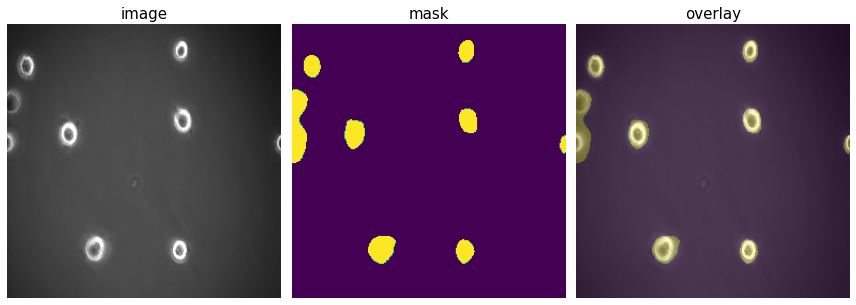

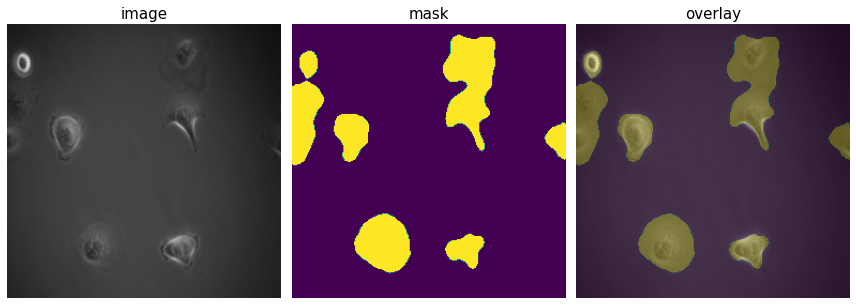

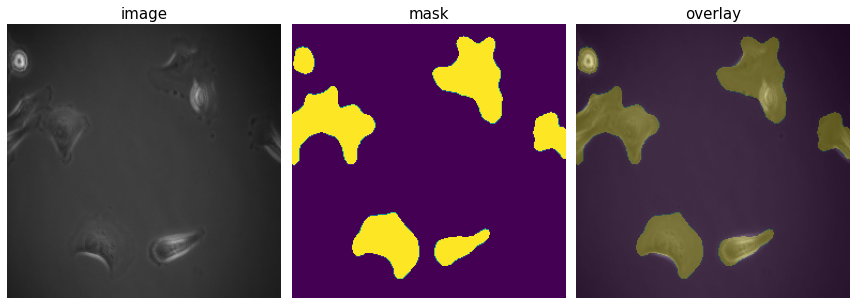

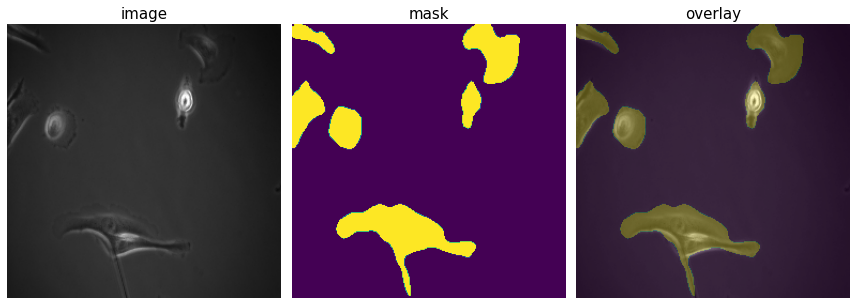

In [21]:
plot_batch(imgs, preds, 4)

## ⏪ Load Model

In [ ]:
pretrained_model_path = '/content/gdrive/MyDrive/pretrained_models/Unet-efficientnetb7-256x256-cm.pth'
entire_model = torch.load(pretrained_model_path)
# entire_model.eval()

In [ ]:
entire_model.items()

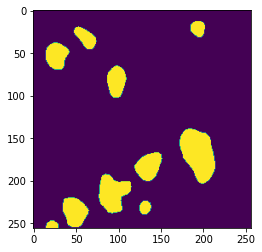

In [29]:
img = cv2.imread('/content/gdrive/MyDrive/Datas/cell_tracking_challenge/train/images/t000.tif', 1)
data = data_transforms['valid'](image=img)
img  = data['image']
pred = entire_model(img)
pred[:, :][pred[:, :] >= .5] = 1
pred[:, :][pred[:, :] < .5] = 0

plt.imshow(np.squeeze(pred.detach().numpy()))